# Проверка гипотез по увеличению выручки для интернет-магазина

## Описание проекта

*Цели и задачи проекта*

Используя данные интернет-магазина приоритезировать гипотезы, произвести оценку результатов A/B-тестирования различными методами. 

*Данные*

В нашем распоряжении три датасета. 

Файл hypothesis.csv хранит список из 9 гипотез, orders.csv — информацию о заказах, а visitors.csv — информацию о пользователях.

Структура hypothesis.csv:
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Структура orders.csv:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Структура visitors.csv:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста.
 
*План*

- предобработка данных
- приоритизация гипотез
- анализ A/B-теста
- принятие решения.

### Общая информация

In [1]:
import scipy.stats as stats
import numpy as np
import math as mth
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12, 5
from pandas.plotting import register_matplotlib_converters
import warnings
pd.options.display.max_colwidth = 400

In [2]:
try:
    hypothesis, orders, visitors = (
    pd.read_csv('/datasets/hypothesis.csv'),
    pd.read_csv('/datasets/orders.csv'),
    pd.read_csv('/datasets/visitors.csv'))
except:
    hypothesis, orders, visitors = (
    pd.read_csv('/Users/porphyrion/Desktop/PRACTICUM/my_projects/datasets/hypothesis.csv'),
    pd.read_csv('/Users/porphyrion/Desktop/PRACTICUM/my_projects/datasets/orders.csv'),
    pd.read_csv('/Users/porphyrion/Desktop/PRACTICUM/my_projects/datasets/visitors.csv'))

In [3]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
hypothesis.columns = [x.lower() for x in hypothesis.columns.values]
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [6]:
orders['date'] = pd.to_datetime(orders['date'])

In [7]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [8]:
orders.duplicated().sum()

0

In [9]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [10]:
visitors['date'] = pd.to_datetime(visitors['date'])

In [11]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


### Предобработка данных

Проверим корректность разбиения пользователей на группы.

In [12]:
#проверим, есть ли пользователи, попавшие в обе группы
AB_users = orders.pivot_table(index='visitorId', values='group', aggfunc='nunique')
AB_users.value_counts()

group
1        973
2         58
dtype: int64

58 пользователей числятся в обеих группах. Необходимо удалить их из теста.

In [13]:
#удалим таких пользователей из теста
AB_users = AB_users[AB_users['group'] == 1]
orders = orders[orders['visitorId'].isin(AB_users.index)]
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A


### Приоритизация гипотез

Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [14]:
hypothesis['ICE'] = (hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']).round(2)
hypothesis_ice = hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)
hypothesis_ice

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [15]:
hypothesis['RICE'] = (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']).round(2)
hypothesis_rice = hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)
hypothesis_rice 

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Объединим результаты в общей таблице.

In [16]:
hypothesis_merge = pd.merge(
    hypothesis_ice,
    hypothesis_rice,
    on=[hypothesis_ice.index, hypothesis_rice.index]
)\
.rename(
    columns={
        'key_0': 'H_ICE', 
        'hypothesis_x': 'hypothesis_ICE',  
        'key_1': 'H_RICE', 
        'hypothesis_y': 'hypothesis_RICE', 
    }
)
hypothesis_merge = hypothesis_merge[['H_ICE', 'hypothesis_ICE', 'ICE', 'H_RICE', 'hypothesis_RICE', 'RICE']]
hypothesis_merge.style.background_gradient(cmap='Blues', subset=['RICE']) \
.background_gradient(cmap='Reds', subset=['ICE'])

,H_ICE,hypothesis_ICE,ICE,H_RICE,hypothesis_RICE,RICE
0,8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.000000
1,0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.330000,2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.000000
2,7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.000000
3,6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.000000
4,2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
5,1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.000000
6,5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.330000,1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.000000
7,3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.120000,5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.000000
8,4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.000000


При применении RICE вместо ICE приоритизация гипотез изменилась.\
Отобразим изменения на графике.

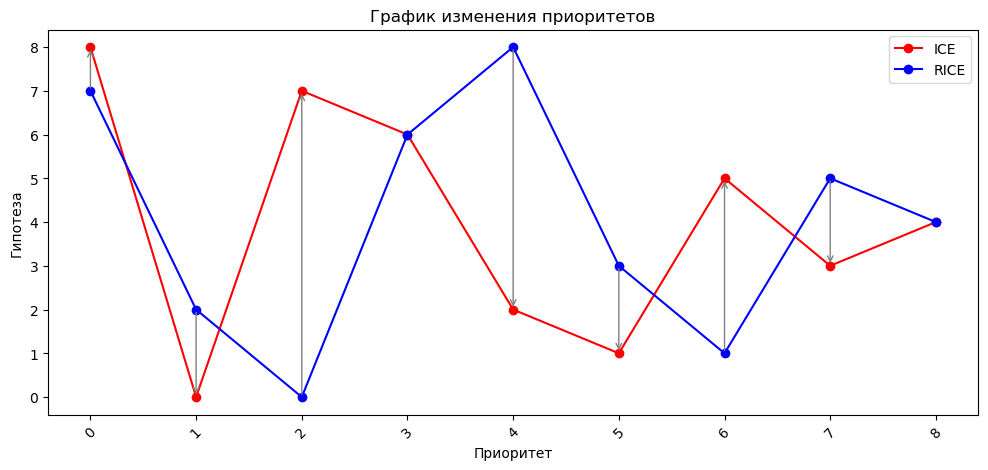

In [17]:
fig, ax = plt.subplots()

x = hypothesis_merge.index
y1 = hypothesis_merge['H_ICE']
y2 = hypothesis_merge['H_RICE']

ax.plot(x, y1, 'o-', color='red', label='ICE')
ax.plot(x, y2, 'o-', color='blue', label='RICE')

for i, (y1_i, y2_i) in enumerate(zip(y1, y2)):
    ax.annotate("", xy=(i, y1_i), xytext=(i, y2_i),
                arrowprops=dict(arrowstyle="->", color='gray'))

plt.title("График изменения приоритетов")
plt.xlabel("Приоритет")
plt.xticks(np.arange(len(x)), x, rotation=45)
plt.ylabel("Гипотеза")
plt.legend()

plt.show()


***Наблюдение.*** \
Наиболее перспективные гипотезы по ICE: 8, 0, 7, 6.\
С учетом охвата по RICE гипотеза 7 на первом месте, так как ее параметр REACH равен 10.\
У гипотезы 2 REACH равен 8, она на втором месте.\
Гипотезы 0 и 6 остались в приоритете после смены метода.\
Итого перспективные гипотезы по RICE: 7, 2, 0, 6.

### Анализ A/B-теста

#### Построим график кумулятивной выручки по группам.

Чтобы построить графики, нужно собрать кумулятивные данные. Объявим датафрейм cumulativeData со столбцами: 
- date — дата;
- group — группа A/B-теста (A или B);
- orders — кумулятивное количество заказов на указанную дату в указанной группе;
- buyers — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
- revenue — кумулятивная выручка на указанную дату в указанной группе (средний чек);
- visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

In [18]:
#Создадим массив уникальных пар значений дат и групп теста. 
datesGroups = orders[['date','group']].drop_duplicates()

#Соберём агрегированные кумулятивные по дням данные о заказах.
ordersAggregated = datesGroups\
.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1)\
.sort_values(by=['date','group'])

#Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина.
visitorsAggregated = datesGroups\
.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
.sort_values(by=['date','group'])

#Объединим кумулятивные данные в одной таблице
cumulativeData = ordersAggregated\
.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


Построим графики кумулятивной выручки по дням и группам A/B-тестирования.

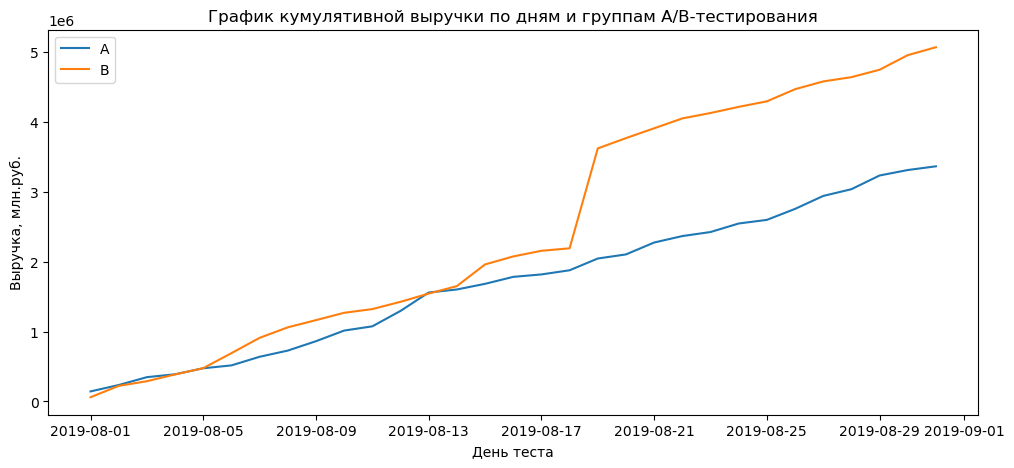

In [19]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

register_matplotlib_converters()

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title("График кумулятивной выручки по дням и группам A/B-тестирования")
plt.xlabel("День теста")
plt.ylabel("Выручка, млн.руб.")
plt.legend()

plt.show()

***Наблюдение.*** \
Выручка почти равномерно увеличивается в течение всего теста. Хороший знак.\
Однако график выручки группы B в середине теста резко вырывается вперед и продолжает лидировать.\
Это может сигнализировать о всплеске числа заказов, либо о появлении очень дорогих заказов в выборке.\
При заключительном анализе их нужно будет удалить.

#### Построим график кумулятивного среднего чека по группам.

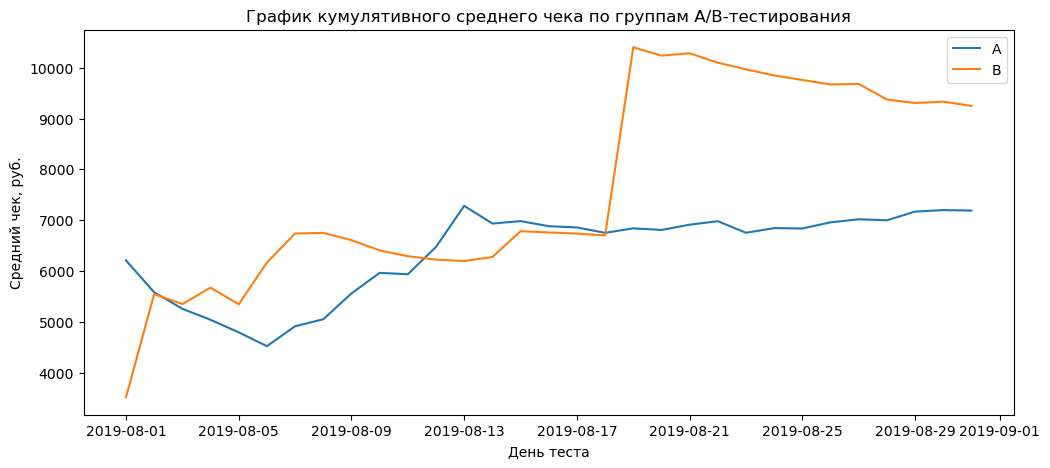

In [20]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title("График кумулятивного среднего чека по группам A/B-тестирования")
plt.xlabel("День теста")
plt.ylabel("Средний чек, руб.")
plt.legend()

plt.show()

***Наблюдение.*** \
Средний чек для группы A становится равномерным ближе к концу теста.\
Возможно, в группу B в середине теста попали крупные заказы (резкий всплеск на графике).\
Скорее всего, принимать решение по этой метрике рано.

#### Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

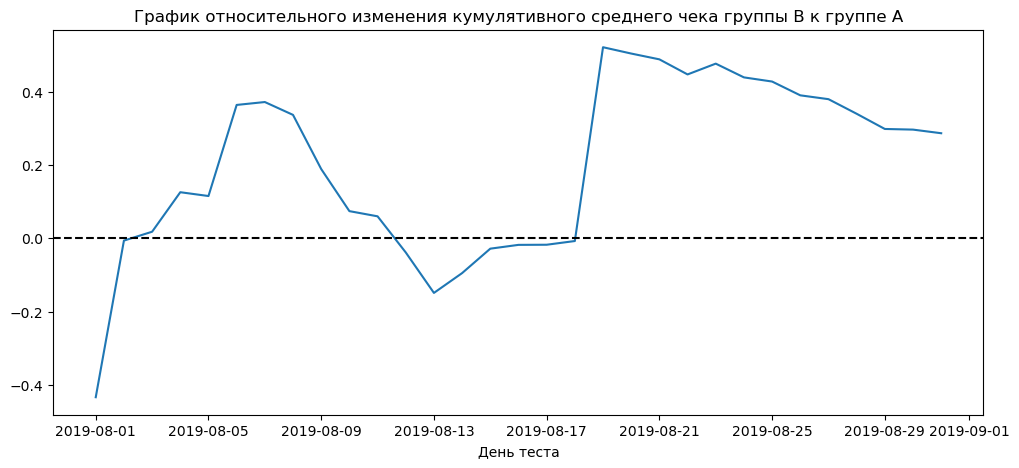

In [21]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA\
.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title("График относительного изменения кумулятивного среднего чека группы B к группе A")
plt.xlabel("День теста")

plt.show()

***Наблюдение.*** \
Результаты теста значительно и резко менялись в некоторые дни.\
Возможно, в эти дни были совершены аномально крупные заказы.

#### Построим график кумулятивного среднего количества заказов на посетителя по группам.

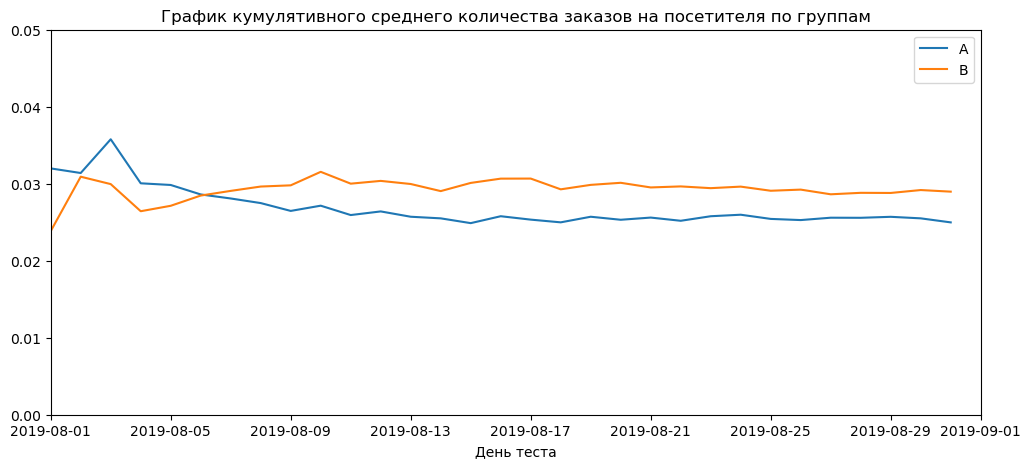

In [22]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

# задаем масштаб осей
plt.axis(['2019-08-01', '2019-09-01', 0, 0.05])

plt.title("График кумулятивного среднего количества заказов на посетителя по группам")
plt.xlabel("День теста")
plt.legend()

plt.show()

***Наблюдение.*** \
В начале теста сегмент А имел конверсию выше В, но постепенно сегмент В выравнился и зафиксировался около одного значения, а конверсия группы А просела и также зафиксировалась.

#### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

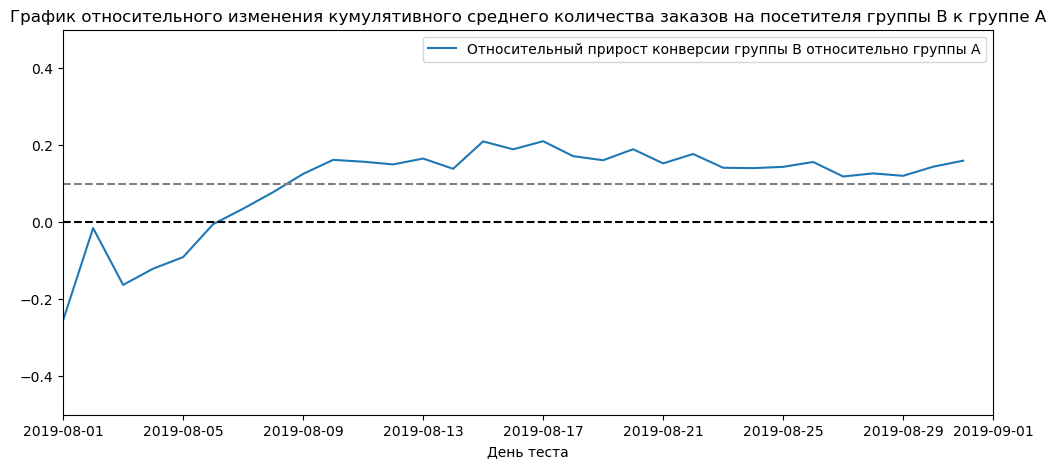

In [23]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']]\
.merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")

plt.title("График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A")
plt.xlabel("День теста")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.5, 0.5])

plt.show()

***Наблюдение.*** \
Почти с самого начала теста группа В лидирует по конверсии и ближе к концу зафиксировалась около прироста в 10% относительно группы А. 

#### Построим точечный график количества заказов по пользователям.

In [24]:
#Подсчитаем количество заказов по пользователям
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsers.columns = ['visitorId', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,visitorId,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


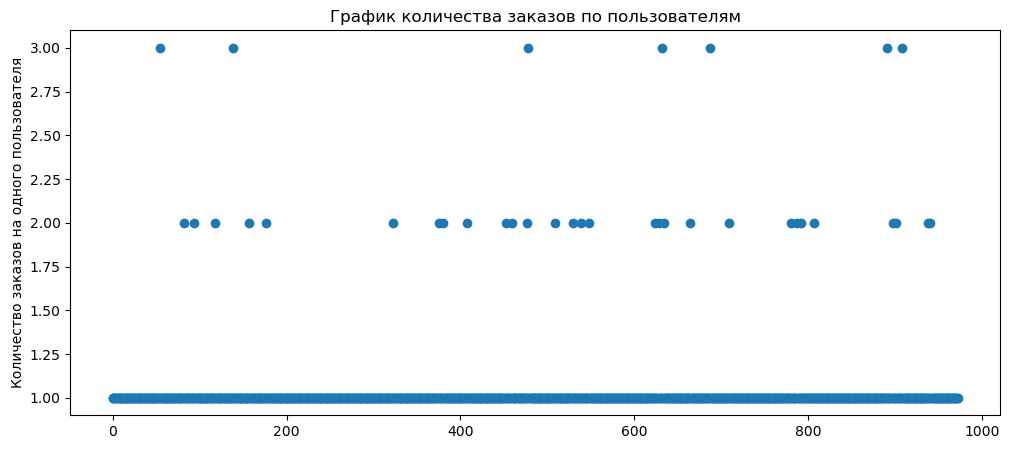

In [25]:
#Построим точечную диаграмму числа заказов на одного пользователя
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])

plt.title("График количества заказов по пользователям")
plt.ylabel("Количество заказов на одного пользователя")

plt.show()

***Наблюдение.*** \
Пользователей, сделавших заказ более двух раз, мало. Они вполне могут быть аномалиями.\
Есть пользователи с двумя заказами. Посчитаем их точную долю, чтобы оценить их нормальность.

#### Выберем границу для определения аномальных пользователей.

In [26]:
#Посчитаем 95-й и 99-й перцентили количества заказов на пользователя

np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

***Наблюдение.*** \
Не более 5% пользователей совершили больше одного заказа.\
Не более 1% пользователей совершили больше двух заказов.\
Разумно выбрать 1 заказ на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней.

#### Построим точечный график стоимостей заказов.

In [27]:
orders.sort_values(by='revenue', ascending=False).head(10)

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
743,3603576309,4133034833,2019-08-09,67990,A
1103,1348774318,1164614297,2019-08-12,66350,A
1099,316924019,148427295,2019-08-12,65710,A
949,1347999392,887908475,2019-08-21,60450,A
940,2420050534,4003628586,2019-08-08,58550,B
131,3163614039,2254586615,2019-08-22,53904,A


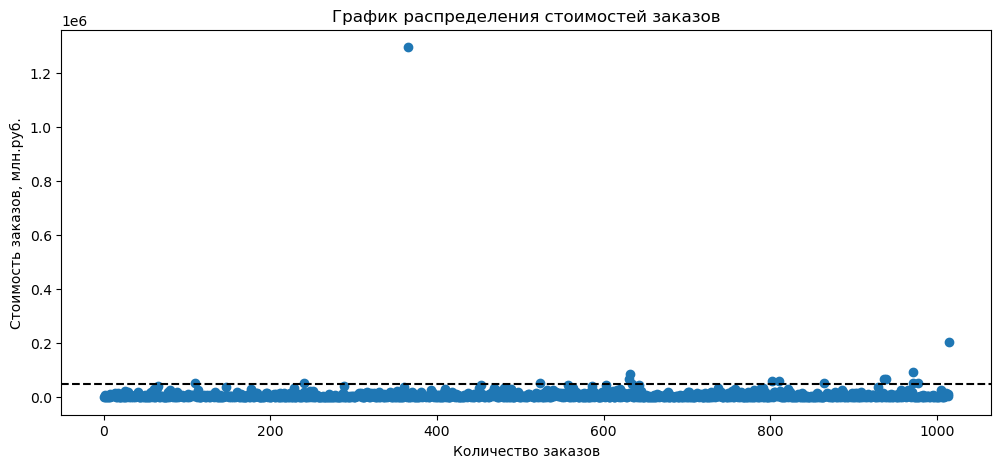

In [28]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.axhline(y=50000, color='black', linestyle='--')

plt.title("График распределения стоимостей заказов")
plt.ylabel("Стоимость заказов, млн.руб.")
plt.xlabel('Количество заказов')

plt.show()

***Наблюдение.*** \
Заказов стоимостью больше 50 000 рублей очень мало.\
Есть отдельные выбросы около 200 000 и 1 200 000 рублей.\
Посчитаем выборочные перцентили, чтобы принять решение о границах аномалий.

#### Выберем границу для определения аномальных заказов.

In [29]:
#Посчитаем 95-й и 99-й перцентили среднего чека в выборке

np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

***Наблюдение.*** \
Не более 5% заказов дороже 26 785 рублей и не более 1% дороже 58 904 рублей.\
Целесообразно принять за верхнюю границу заказы стоимостью 27 000 рублей и отсеять аномалии по ней. 

#### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 

***Сформулируем гипотезы.*** \
*H0:* Нет различий в среднем количестве заказов между группами A и B.\
*H1:* Есть различия в среднем между группами A и B.

Подготовим данные для работы:
- date — дата;
- ordersPerDateA — количество заказов в выбранную дату в группе A;
- revenuePerDateA — суммарная выручка в выбранную дату в группе A;
- ordersPerDateB — количество заказов в выбранную дату в группе B;
- revenuePerDateB — суммарная выручка в выбранную дату в группе B;
- ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
- revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
- ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
- revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
- visitorsPerDateA — количество пользователей в выбранную дату в группе A;
- visitorsPerDateB — количество пользователей в выбранную дату в группе B;
- visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
- visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

In [30]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

raw_data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

raw_data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Посчитаем статистическую значимость различия в среднем количестве заказов между группами.

In [31]:
#Создадим переменные ordersByUsersA и ordersByUsersB. 
#В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

In [32]:
#Объявим переменные sampleA и sampleB, в которых пользователям из разных групп 
#будет соответствовать количество заказов. 
#Тем, кто ничего не заказал, будут соответствовать нули.

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                raw_data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                raw_data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value', "{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value 0.01102
0.160


***Наблюдение.*** \
P-value меньше 0.05, поэтому отвергаем нулевую гипотезу.\
Анализ сырых данных сообщает, что между группами есть статистически значимые различия в среднем количестве заказов.\
Относительный прирост среднего группы В к конверсии группы А равен 16%.

#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

*Н0:* Нет различий в среднем чеке между группами А и В.\
*Н1:* Есть различия в среднем чеке между группами А и В.

In [33]:
#статистическая значимость различия средних чеков между группами 
print('p-value', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

#относительные различия в среднем чеке между группами
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value 0.829
0.287


***Наблюдение.*** \
P-value значительно больше 0.05.\
Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.\
Наблюдаемое относительное различие среднего чека между сегментами в 28.7% не является статистически значимым.\
Необходим анализ аномалий.

#### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

Найденные 95-й и 99-й перцентили средних чеков равны 26 785 и 58 904 рублям.\
А 95-й и 99-й перцентили количества заказов на одного пользователя равны 1 и 2 заказа на пользователя.\
Примем за аномальных пользователей тех, кто совершил более 1 заказа или совершил заказ дороже 27 000 рублей.\
Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами

In [34]:
revenue_lim = np.percentile(orders['revenue'], 95)
orders_lim = np.percentile(ordersByUsers['orders'], 95)

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > orders_lim]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > orders_lim]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > revenue_lim]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
Name: visitorId, dtype: int64
86


Всего 86 аномальных пользователей. 

Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным.

In [35]:
#Сначала подготовим выборки количества заказов по пользователям по группам теста
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                raw_data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                raw_data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [36]:
#Применим статистический критерий Манна-Уитни к полученным выборкам
print('p-value', '{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value 0.01593
0.174


***Наблюдение.*** \
Как и в случае с сырыми данными, p-value меньше 0.05, поэтому отвергаем нулевую гипотезу.\
Между группами есть статистически значимые различия в среднем количестве заказов.\
Относительный прирост среднего группы В к конверсии группы А равен 17.4%.

#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [37]:
print('p-value', 
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value 0.727
-0.034


***Наблюдение.*** \
P-value так же больше 0.05.\
Разница между сегментами в 3.4% не является статистически значимой.\
Принимаем нулевую гипотезу о равенстве среднего чека.

### Принятие решения по результатам теста

***Выводы:***
- Анализ сырых данных и анализ после фильтрации аномалий сообщают, что между группами есть статистически значимые различия в среднем количестве заказов;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График различия среднего количества заказов между группами сообщает, что результаты группы B лучше группы A на 10%;

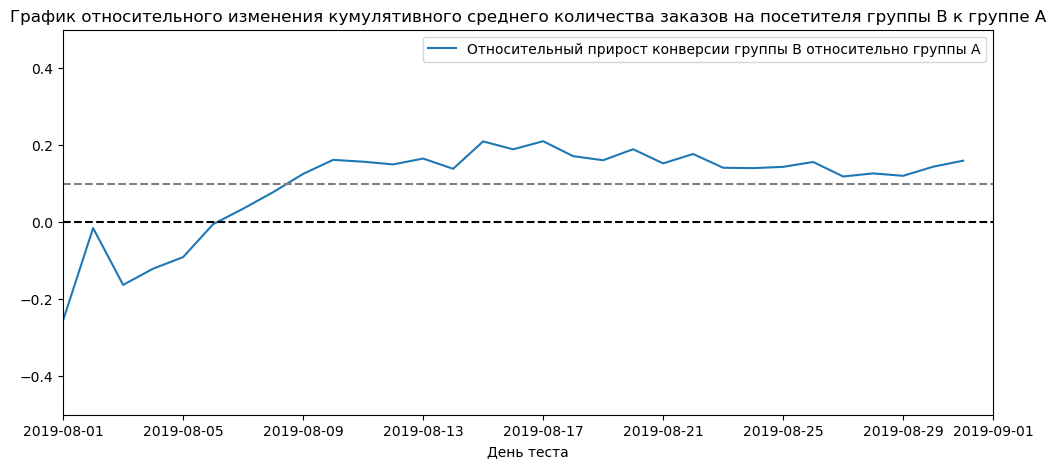

In [38]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']]\
.merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")

plt.title("График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A")
plt.xlabel("День теста")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.5, 0.5])

plt.show()

- График различия среднего чека говорит о том, что результаты группы B снижаются, однако сейчас почти на 30% лучше результатов группы А:

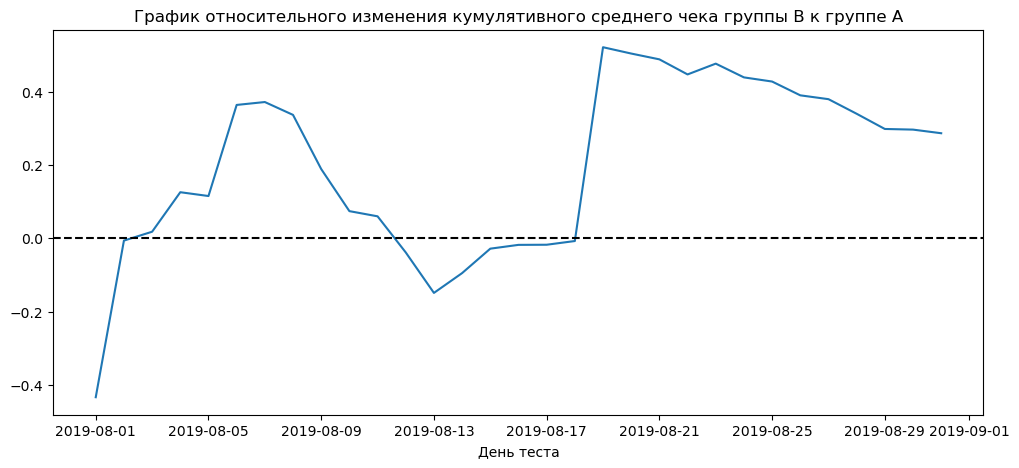

In [39]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA\
.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title("График относительного изменения кумулятивного среднего чека группы B к группе A")
plt.xlabel("День теста")

plt.show()

***Решение.*** \
Исходя из обнаруженных фактов, тест следует остановить и зафиксировать победу сегмента В.\
Несмотря на отсутствие статистически значимой разницы между средними чеками сегментов, разница в количестве заказов подтверждена.\
Относительный прирост среднего группы В к конверсии группы А равен 17.2% после фильтрации аномалий.